# Sample Size Calculation For AB Test
This notebook provides a busineses practical solution to calculate sample size for AB Test. 
<br>
It discuss the relationship between sample size and minimun detectable effect (i.e. a practical difference that can be appreciated in business world), given a fixed significance level and power. 
<br>
It does not discuss the trade off between significance level and power. 

## 1. Background
The team plan to run an online Campaign called "An_Online_Campaign" that aims to improving user conversion. The team decide to run an AB Test to evaluate the impact of the campaign. 
<br>Before launching the test, the team need to know the sample size. Why? Because sample size impact statistical power. We want the test to have sufficient statistical power, so that the test will detect a significant difference when there is truly a difference. 
<br>
<br>The statistical power can be calculated as:
$$
  Z_{1-\beta} = 
              -Z_{1-\alpha/2}
              + \frac
                     {\Delta}
                     {\sqrt{\frac{\sigma_1^2}{n_1}+\frac{\sigma_2^2}{n_2}}}
$$
Where:
* $n_1$: sample size of population 1
* $\sigma_1^2$: variance of population 1
* $n_2$: sample size of population 2
* $\sigma_2^2$: variance of population 2
* $1-\alpha/2$: confidence level
* $1-\beta$: statistical power
* $\Delta$: minimun detectable effect, the absolute difference between two populations, |$\mu_1$-$\mu_2$|

<br>
There are two ways to run the AB test for An_Online_Campaign:

* Comparing Two Means: comparing daily Conversion Rate between Treatment and Control groups
* Comparing Two Proportions: comparing individual users' conversion between Treatment and Control groups

Hence there are two approaches to calculate sample size. 
<br>We will demonstrate the two approaches below.

## 2. Sample Size For Comparing Two Means
Since we are comparing the difference of daily Conversion Rate between Treatment and Control groups, the sample size is the number of days in testing window.
<br>
We assume $n_1$=$n_2$=$n$, and Treatment and Control have the same variance, i.e. $\sigma_1^2$=$\sigma_2^2$=$\sigma^2$
<br>So:
$$
  n = \frac{2\sigma^2(Z_{1-\beta}+Z_{1-\alpha/2})^2}
            {\Delta^2}
$$
Where:
* $n$: the number of days in testing window
* $\sigma^2$: the variance of pool
* $1-\alpha/2$: confidence level
* $1-\beta$: statistical power
* $\Delta$: minimun detectable effect, the absolute difference between Test and Control groups, |$\mu_1$-$\mu_2$|

Let's use this approach to calculate sample size for An_Online_Campaign. I will demostrate by creating a dataset of user and convertion, apply the formula on the dataset, and visualize the results with charts.

In [69]:
import pandas as pd
import random
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [95]:
start_date = datetime(2022, 1, 1)
end_date = start_date + timedelta(days=29)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

data = []
i = 0

for date in date_range:
    # Generate 100 unique user IDs for each date
    user_ids = range(1+(i*100), 101+(i*100))
    
    # Generate a random is_converted value (0 or 1) for each user ID
    is_converted = [random.choice([0, 1]) for _ in user_ids]
    
    date_data = [(date, uid, converted) for uid, converted in zip(user_ids, is_converted)]
    data.extend(date_data)
    i+=1

#flatten list
tab_user_convert = pd.DataFrame(data, columns=['date', 'uid', 'is_converted'])

print('Table tab_user_convert contains individual users\' conversion status in the previous 30 days.\n\nTop 5 rows like this:')
tab_user_convert.head(5)

Table tab_user_convert contains individual users' conversion status in the previous 30 days.

Top 5 rows like this:


,date,uid,is_converted
0,2022-01-01,1,0
1,2022-01-01,2,0
2,2022-01-01,3,1
3,2022-01-01,4,1
4,2022-01-01,5,0


In [94]:
print('From Table tab_user_convert, we created tab_user_conversion to store conversion rate on a daily basis.\n\nTop 5 rows like this:')

tab_user_conversion = tab_user_convert.groupby(by='date')['is_converted'].mean().reset_index()
tab_user_conversion.rename(columns={'is_converted':'conversion_rate'},inplace=True)
tab_user_conversion.head()

From Table tab_user_convert, we created tab_user_conversion to store conversion rate on a daily basis.

Top 5 rows like this:


,date,conversion_rate
0,2022-01-01,0.46
1,2022-01-02,0.53
2,2022-01-03,0.54
3,2022-01-04,0.42
4,2022-01-05,0.52


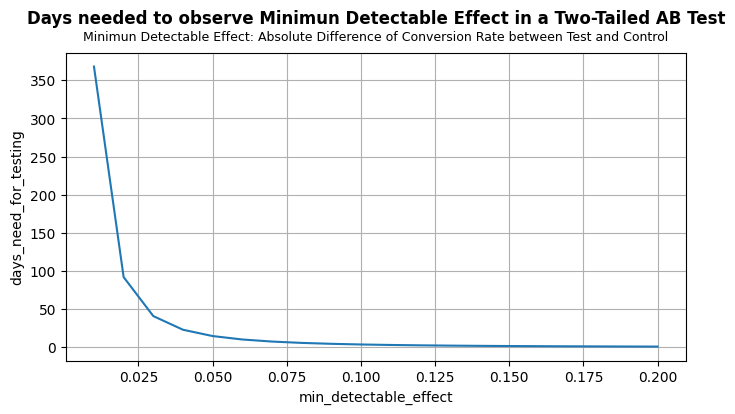

In [127]:
output_lst = []
output_df = pd.DataFrame()
output_dict = {}

# set confidence level as 95% ($alpha$=0.05) and statistical power as 80% ($beta$=0.2): 
z_a = 1.96
z_b = 0.85

# generate a list of numbers ranging from 0.01 to 0.2 with a gap of 0.01
min_detect_effect = [i/100 for i in range(1, 21)]

# population values
var = tab_user_conversion['conversion_rate'].var()

# create dictionary to store results  
for delta in min_detect_effect:
    key = f'Key_{delta}'
    var = var
    n = 2*var*((z_a+z_b)**2)/(delta**2)
    
    output_lst=[]
    output_lst.append([delta, n])
    output_df = pd.DataFrame(output_lst, columns=['min_detectable_effect', 'days_need_for_testing'])
    output_dict[key] = output_df

# flatten dictionary into a table            
sizing_output = pd.concat(output_dict, axis=0).reset_index(drop=True)

# visualization
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(x=sizing_output['min_detectable_effect'], y=sizing_output['days_need_for_testing'])
ax.set_xlabel('min_detectable_effect')
ax.set_ylabel('days_need_for_testing')

ax.set_title('Days needed to observe Minimun Detectable Effect in a Two-Tailed AB Test\n',fontweight='bold')
ax.text(0.5, 1.05, 'Minimun Detectable Effect: Absolute Difference of Conversion Rate between Test and Control', fontdict={'fontsize': 9}, ha='center', va='center', transform=ax.transAxes)

plt.grid(True)
plt.show()

## 3. Sample Size For Comparing Two Proportions
Since we are comparing individual users' conversion rate between Treatment and Control groups, as all the users are conducting a Bernoulli trial (convert or not), so Treatment and Control groups follow a binomial distribution, so the sample size is the number of users in Treatment group. 
<br>In a Binomial Distribution, $\sigma^2$ = $p$(1-$p$)/$n$.
<br>So:
$$
  n_t = \frac{(Z_{1-\beta}+Z_{1-\alpha/2})^2(p_t(1-p_t)+\frac{p_c(1-p_c)}{k})}
            {\Delta^2}
$$
Where:
* $n_t$: the number of users in Treatment group
* $n_c$: the number of users in Control group
* k=$n_c$/$n_t$
* $p_t$,$p_c$: the probabilities of conversion in Treatment and Control groups, respectively
* $1-\alpha/2$: confidence level
* $1-\beta$: statistical power
* $\Delta$: minimun detectable effect, the absolute difference between Test and Control groups, |$p_1$-$p_2$|

Let's use this approach to calculate sample size for An_Online_Campaign. I will use the same dataset created above, apply the formula and visualize the results with charts.

In [121]:
treatment,control = train_test_split(tab_user_convert,test_size=0.4) 

p_treatment = treatment['is_converted'].sum()/treatment['is_converted'].count()
p_control = control['is_converted'].sum()/control['is_converted'].count()

print('We randomly split Table tab_user_convert into Treatment and Control groups.')
print('')
print('Users in Treatment:', treatment.shape[0], '  Proportion in Treatment:', p_treatment)
print('Users in Control:', control.shape[0], '    Proportion in Control:', p_control)

We randomly split Table tab_user_convert into Treatment and Control groups.

Users in Treatment: 1800   Proportion in Treatment: 0.5133333333333333
Users in Control: 1200     Proportion in Control: 0.5083333333333333


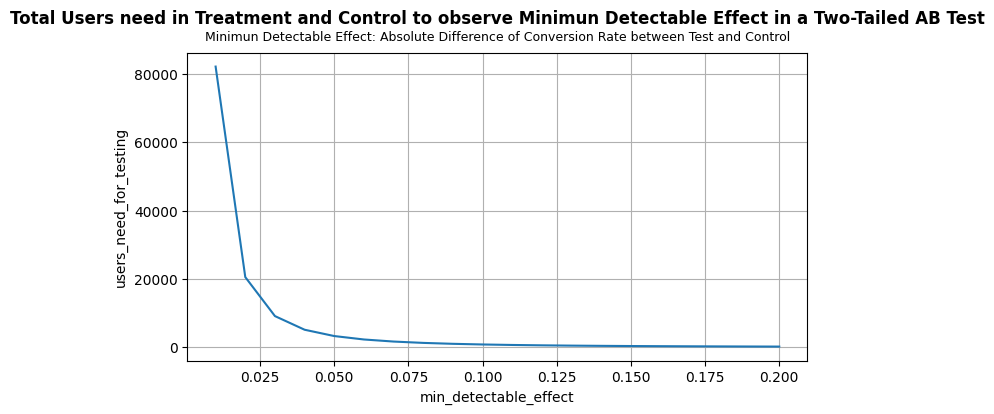

In [128]:
output_lst = []
output_df = pd.DataFrame()
output_dict = {}

# set confidence level as 95% ($alpha$=0.05) and statistical power as 80% ($beta$=0.2): 
z_a = 1.96
z_b = 0.85

# generate a list of numbers ranging from 0.01 to 0.2 with a gap of 0.01
min_detect_effect = [i/100 for i in range(1, 21)]

# population values
p_1 = p_treatment
p_2 = p_control
k = control.shape[0]/treatment.shape[0]

# create dictionary to store results  
for delta in min_detect_effect:
    key = f'Key_{delta}'
    n_1 = ((z_a+z_b)**2)*(p_1*(1-p_1)+p_2*(1-p_2)/k)/(delta**2)
    n = n_1 + n_1*k  # sample for treatment + control
    output_lst=[]
    output_lst.append([delta, n])
    output_df = pd.DataFrame(output_lst, columns=['min_detectable_effect', 'users_need_for_testing'])
    output_dict[key] = output_df

# flatten dictionary into a table            
sizing_output = pd.concat(output_dict, axis=0).reset_index(drop=True)

# visualization
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(x=sizing_output['min_detectable_effect'], y=sizing_output['users_need_for_testing'])
ax.set_xlabel('min_detectable_effect')
ax.set_ylabel('users_need_for_testing')

ax.set_title('Total Users need in Treatment and Control to observe Minimun Detectable Effect in a Two-Tailed AB Test\n',fontweight='bold')
ax.text(0.5, 1.05, 'Minimun Detectable Effect: Absolute Difference of Conversion Rate between Test and Control', fontdict={'fontsize': 9}, ha='center', va='center', transform=ax.transAxes)

plt.grid(True)
plt.show()